# Judge Hiciano Jupyter Notebook

In [31]:
# Imports required for project
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

# Plotting
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from pprint import pprint

# sklearn Metrics and tunning
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#import machine learning related libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb



In [32]:
pd.options.display.max_rows = 50000
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)

## Description of variables
• sessionID: Session ID. 1-50000 in train.csv, 50001-55111 in test.csv.

• hour: Hour when the session was started. Numbers between 0 and 23.

• weekday: Day of the week when the session was started. 5: Friday, 6: Saturday, 7: Sunday, 1: Monday.

• duration: Time in seconds passed since the start of the session.

• clickCount: Number of products that were visited (clicked).

• clickMin: Lowest price of the products visited (clicked).

• clickMax: Highest price of the products visited (clicked).

• clickTotal: Sum of the prices of all the products visited (clicked).

• cartCount: Number of products that were added to the cart.

• cartMin: Lowest price of the products in the cart.

• cartMax: Highest price of the products in the cart.

• cartTotal: Sum of the prices of all the products in the cart.

• cartStep: Purchase processing step. Possible values: 1,2,3,4,5.

• status: Whether the customer is online. ‘y’: yes. ‘n’: no.

• availability: Whether the cart is orderable or not. There are seven possible values.

• customerID: customer ID. 1-25038 in train.csv. In test.csv there exist both old and new customers.

• purchase: Highest purchase price in history for the customer.

• score: Customer score evaluated by the online store.

• account: Lifetime of the customer’s account in months.

• payments: Number of payments made by the customer.

• age: Age of the customer.

• salutation: Salutation of the customer. 1: Mr, 2: Ms, 3: Company.

• lastOrder: Time in days passed since the last order.

• order: (Response variable) Whether the order is placed. ‘y’: yes. ‘n’: no.


In [33]:
df_train = pd.read_csv("../data/train.csv") 
df_test = pd.read_csv("../data/test.csv")

In [34]:
# sns.pairplot(df_train, hue="ordered")

In [35]:
# dfxx = df_train.groupby(['score','order'])['order'].count()
# dfxx.head(5)

In [36]:
common_drops = ['sessionID',
                'customerID',
                'weekday',
                 'status',
#                'availability',
#                 'cartStep',
                 'purchase',
#                 'score',                 
                'payments',
                'account',
                'lastOrder',
                 'salutation',
                 'age',
#                 'cartCount',
#                 'clickMin',
#                 'cartMin',
                 'hour',
                'duration',
#                 'clickCount',
#                 'clickMax',
#                 'cartMax',
#                 'clickTotal',
#                 'cartTotal'
               ]

common_drops = ['sessionID','hour','weekday','duration','clickTotal']
drop_columns_train = common_drops
drop_columns_submission = common_drops

## Feature Enigneering on Training Data

Currently droping 'order', 'sessionID', and 'age' 

In [37]:
print(len(df_train))
df_train['score'].fillna(-1, inplace=True)
df_train['sess_count'] = df_train.groupby('sessionID')['sessionID'].transform('count')
df_train['customer_total_orders'] = df_train.groupby('customerID')['customerID'].transform('count')
df_train['total_duration'] = df_train.groupby('sessionID')['duration'].transform('sum')
df_train.loc[df_train['customerID'] >= 0,'is_customer'] = 1
df_train['is_customer'].fillna(0, inplace=True)
df_train['cartStep'].fillna(-1, inplace=True)
df_train['customerID'].fillna(-1, inplace=True)
df_train['missing_items_total'] = df_train['clickTotal']-df_train['cartTotal']
df_train['ordered'] = (df_train['order'] !='n').astype(int) #Converts string `order` to int value for training
df_train = df_train.drop(['order'], axis=1)
df_train.dropna(thresh=16,inplace=True)
df_train = pd.get_dummies(df_train)
print(len(df_train))
df_train.head(20)

429013
426832


,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,ordered,status_n,status_y,availability_completely not determinable,availability_completely not orderable,availability_completely orderable,availability_mainly not determinable,availability_mainly not orderable,availability_mainly orderable,availability_mixed
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,59.99,59.99,-1.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.00,1,0,0,0,0,0,0,0,0,0
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.00,1,0,1,0,0,1,0,0,0,0
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,-1.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.00,1,0,1,0,0,1,0,0,0,0
8,3,6,5,181.477,9,29.99,29.99,89.97,1,29.99,29.99,29.99,-1.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,59.98,1,0,0,0,0,0,0,0,0,0
9,3,6,5,297.018,11,9.99,29.99,109.95,2,9.99,29.99,39.98,-1.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,69.97,1,0,0,0,0,0,0,0,0,0
10,3,6,5,310.967,11,9.99,29.99,109.95,2,9.99,29.99,39.98,-1.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,69.97,1,0,1,0,0,1,0,0,0,0
11,3,6,5,324.278,11,9.99,29.99,109.95,2,9.99,29.99,39.98,4.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,69.97,1,0,1,0,0,1,0,0,0,0
12,3,6,5,341.613,11,9.99,29.99,109.95,2,9.99,29.99,39.98,-1.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,69.97,1,0,1,0,0,1,0,0,0,0
13,4,6,5,28.871,4,4.99,4.99,19.96,1,4.99,4.99,4.99,-1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,2,NaN,71.683,0.0,14.97,0,0,0,0,0,0,0,0,0,0
14,4,6,5,42.812,4,4.99,4.99,19.96,1,4.99,4.99,4.99,1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,2,NaN,71.683,0.0,14.97,0,0,1,0,1,0,0,0,0,0


In [38]:
df_train = df_train.drop(['status_n'], axis=1)
df_train = df_train.drop(['availability_completely not determinable'], axis=1)
df_train = df_train.drop(['availability_mainly not determinable'], axis=1)
df_train = df_train.drop(['availability_mainly not orderable'], axis=1)
df_train = df_train.drop(['availability_mainly orderable'], axis=1)
df_train = df_train.drop(['availability_mixed'], axis=1)

In [21]:
# q = df_train["sess_count"].quantile(0.99)
# df_train = df_train[df_train["sess_count"] < q]
df_train.head(5)

,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,ordered,status_y,availability_completely not orderable,availability_completely orderable
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,59.99,59.99,999.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.00,1,0,0,0
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.00,1,1,0,1
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,999.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.00,1,1,0,1
8,3,6,5,181.477,9,29.99,29.99,89.97,1,29.99,29.99,29.99,999.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,59.98,1,0,0,0
9,3,6,5,297.018,11,9.99,29.99,109.95,2,9.99,29.99,39.98,999.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,69.97,1,0,0,0


In [51]:
df_train_clensed = df_train.drop(drop_columns_train,axis=1)
df_train_clensed = pd.get_dummies(df_train_clensed)
#df_train_clensed = df_train_clensed.drop('status_n', axis =1 )
# df_train_clensed.head()
# df_train_clensed.dropna(thresh=4,inplace=True)
df_train_clensed =pd.DataFrame(df_train_clensed).fillna(-1)
print(len(df_train_clensed))
df_train_clensed.info()
#df_train_clensed.groupby(by=df_train_clensed.columns, axis=1).sum()
df_train_clensed.head(2)


426832
<class 'pandas.core.frame.DataFrame'>
Int64Index: 426832 entries, 0 to 429012
Data columns (total 25 columns):
clickCount                               426832 non-null int64
clickMin                                 426832 non-null float64
clickMax                                 426832 non-null float64
cartCount                                426832 non-null int64
cartMin                                  426832 non-null float64
cartMax                                  426832 non-null float64
cartTotal                                426832 non-null float64
cartStep                                 426832 non-null float64
customerID                               426832 non-null float64
purchase                                 426832 non-null float64
score                                    426832 non-null float64
account                                  426832 non-null float64
payments                                 426832 non-null float64
age                                      

,clickCount,clickMin,clickMax,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,ordered,status_y,availability_completely not orderable,availability_completely orderable
0,1,59.99,59.99,1,59.99,59.99,59.99,-1.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.0,1,0,0,0
1,1,59.99,59.99,1,59.99,59.99,59.99,2.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.0,1,1,0,1


In [21]:
df_train_clensed = df_train_clensed.drop(['customerID'], axis=1)

In [39]:
df_train_new.drop(df_train_new.index, inplace=True)
df_train_new = df_train.groupby(['sessionID'])['duration'].sum()
df_train_new = df_train_new.reset_index()
df_train_new['ordered'] = df_train.groupby(['sessionID'])['ordered']
df_train_new['session_count'] = df_train.groupby('sessionID').count().reset_index()['hour']


temp_list = ['sessionID','ordered','clickCount','score','is_customer','customerID','cartTotal','clickTotal','purchase','cartCount','customer_total_orders','cartStep']
gb_list = ['sessionID','ordered','score','is_customer','customer_total_orders','purchase','customerID']

df_temp = df_train[temp_list]
df_temp2 = df_temp.groupby(gb_list, as_index=False)['clickCount'].max()
df_temp3 = df_temp.groupby(gb_list, as_index=False)['clickTotal'].max()
df_temp4 = df_temp.groupby(gb_list, as_index=False)['cartTotal'].max()
df_temp5 = df_temp.groupby(gb_list, as_index=False)['cartCount'].max()

In [40]:
df_temp6 = df_temp.groupby(gb_list, as_index=False)['cartStep'].max()

In [ ]:
df_train['order_chance'] = df_train['ordered'].groupby(df_train['customerID']).mean()
print(len(df_train))
df_train.head(1)

In [ ]:
df_train.loc[df_train['cartStep'] == 5]

df_train[['customerID','cartStep','ordered']].groupby(['customerID','cartStep','ordered']).sum().head(100)

In [41]:
df_train_new['order'] = df_temp2['ordered']
df_train_new['clickCount'] = df_temp2['clickCount']
df_train_new['score'] = df_temp2['score']
df_train_new['is_customer'] = df_temp2['is_customer']
df_train_new['purchase'] = df_temp2['purchase']
df_train_new['cartCount'] = df_temp5['cartCount']
df_train_new['cartTotal'] = df_temp4['cartTotal']
df_train_new['clickTotal'] = df_temp3['clickTotal']
df_train_new['customerID'] = df_temp3['customerID']
df_train_new['cartStep'] = df_temp6['cartStep']
df_train_new['customer_total_orders'] = df_temp3['customer_total_orders']
#df_train_new.set_index('customerID').join(df_train_222.set_index('customerID'))
# df_train_new = df_train_new.merge(
#                  df_order_chance,
#                  on='customerID')
print(len(df_train_new))
df_train_new.loc[df_train_new['customerID'] == 5]

49760


,sessionID,duration,ordered,session_count,order,clickCount,score,is_customer,purchase,cartCount,cartTotal,clickTotal,customerID,cartStep,customer_total_orders
3,5,12310.330,"(5, [1, 1, 1, 1, 1, 1, 1, 1])",8,1.0,15.0,575.0,1.0,900.0,3.0,9.0,137.0,5.0,4.0,17.0
20670,20793,97.911,"(20793, [0, 0, 0, 0])",4,0.0,48.0,575.0,1.0,900.0,1.0,1.0,165.0,5.0,1.0,17.0


In [50]:
#df_train_new = df_train_new.drop(['ordered'], axis=1)
df_train_new.head(8)
#df_train_new = df_train_new.drop(['customerID'], axis=1)
df_train_new.info()
#df_train_new = df_train_new.drop(['customerID'], axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49760 entries, 0 to 49759
Data columns (total 14 columns):
sessionID                49760 non-null int64
duration                 49760 non-null float64
session_count            49760 non-null int64
order                    27046 non-null float64
clickCount               27046 non-null float64
score                    27046 non-null float64
is_customer              27046 non-null float64
purchase                 27046 non-null float64
cartCount                27046 non-null float64
cartTotal                26728 non-null float64
clickTotal               26968 non-null float64
customerID               27046 non-null float64
cartStep                 27046 non-null float64
customer_total_orders    27046 non-null float64
dtypes: float64(12), int64(2)
memory usage: 5.3 MB


## Adjust Testing Data Set

In [13]:
df_test['score'].fillna(-1, inplace=True)
df_test['sess_count'] = df_test.groupby('sessionID')['sessionID'].transform('count')
df_test['customer_total_orders'] = df_test.groupby('customerID')['customerID'].transform('count')
df_test['total_duration'] = df_test.groupby('sessionID')['duration'].transform('sum')
df_train.loc[df_train['customerID'] >= 0,'is_customer'] = 1
df_train['is_customer'].fillna(0, inplace=True)
df_train['cartStep'].fillna(0, inplace=True)
df_test['missing_items_total'] = df_test['clickTotal']-df_test['cartTotal']
df_test = pd.get_dummies(df_test)
df_test.describe()

,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,missing_items_total,status_n,status_y,availability_completely not determinable,availability_completely not orderable,availability_completely orderable,availability_mainly not determinable,availability_mainly not orderable,availability_mainly orderable,availability_mixed
count,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,44742.000000,44742.000000,44742.000000,45068.000000,44479.000000,44479.000000,44479.000000,24302.000000,27804.000000,27616.000000,45068.000000,27616.000000,27804.000000,27786.000000,27804.000000,27804.000000,45068.000000,27804.000000,4.506800e+04,44479.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000
mean,52385.701185,18.589509,6.458418,1645.291183,27.316810,53.299304,149.135132,1240.985675,4.366668,65.935684,105.750478,209.595122,2.240844,25236.189433,2039.006373,294.743033,129.780997,9.951014,43.281941,1.744497,94.915264,17.163486,19.906272,3.847433e+04,1033.120793,0.004859,0.610056,0.001997,0.003195,0.583185,0.000044,0.000799,0.014511,0.002263
std,1426.206838,5.543531,1.719373,2279.003964,32.549188,146.774665,272.250373,3523.665302,4.333860,172.340996,204.394800,414.707600,1.284694,4087.158333,2157.553606,259.960288,104.308406,13.388516,11.526591,0.439028,125.050807,13.240240,18.701953,7.956577e+04,3272.518633,0.069540,0.487743,0.044643,0.056436,0.493037,0.006662,0.028252,0.119587,0.047520
min,50001.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,47.000000,0.000000,-1.000000,0.000000,0.000000,17.000000,1.000000,4.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51166.000000,19.000000,7.000000,259.884500,6.000000,5.000000,29.990000,154.370000,1.000000,7.990000,19.990000,39.990000,1.000000,25478.000000,600.000000,-1.000000,43.000000,2.000000,35.000000,1.000000,16.000000,8.000000,10.000000,3.768789e+03,79.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52331.000000,20.000000,7.000000,864.808000,15.000000,9.990000,49.990000,445.540000,3.000000,12.990000,34.990000,89.970000,2.000000,26090.000000,1200.000000,457.000000,102.000000,7.000000,43.000000,2.000000,42.000000,14.000000,16.000000,1.373283e+04,313.830000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,53600.000000,21.000000,7.000000,2148.555000,36.000000,24.990000,99.990000,1164.570000,6.000000,29.990000,69.990000,209.850000,3.000000,26681.000000,3000.000000,537.000000,213.000000,13.000000,50.000000,2.000000,123.000000,22.000000,24.000000,4.018059e+04,933.250000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,55111.000000,23.000000,7.000000,21320.113000,200.000000,1999.990000,4799.000000,117310.700000,43.000000,1999.990000,2299.990000,8948.960000,5.000000,27318.000000,25000.000000,614.000000,524.000000,278.000000,90.000000,3.000000,733.000000,87.000000,187.000000,1.172623e+06,108950.790000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
#df_test_new.drop(df_test_new.index, inplace=True)
df_test_new = df_test.groupby(['sessionID'])['duration'].sum()
df_test_new = df_test_new.reset_index()
df_test_new['ordered'] = df_test_new.groupby(['sessionID'])['ordered']
df_test_new['session_count'] = df_test.groupby('sessionID').count().reset_index()['hour']


temp_list_test = ['sessionID','clickCount','score','is_customer','customerID','cartTotal','clickTotal','purchase','cartCount']
gb_list_test = ['sessionID','score','is_customer','purchase','customerID']

df_temp = df_test[temp_list_test]
df_temp2 = df_temp.groupby(gb_list_test, as_index=False)['clickCount'].max()
df_temp3 = df_temp.groupby(gb_list_test, as_index=False)['clickTotal'].max()
df_temp4 = df_temp.groupby(gb_list_test, as_index=False)['cartTotal'].max()
df_temp5 = df_temp.groupby(gb_list_test, as_index=False)['cartCount'].max()
df_test_new.head()

KeyError: 'Column not found: ordered'

In [827]:
df_test_new['clickCount'] = df_temp2['clickCount']
df_test_new['score'] = df_temp2['score']
df_test_new['is_customer'] = df_temp2['is_customer']
df_test_new['purchase'] = df_temp2['purchase']
df_test_new['cartCount'] = df_temp5['cartCount']
df_test_new['cartTotal'] = df_temp4['cartTotal']
df_test_new['clickTotal'] = df_temp3['clickTotal']
df_test_new['customerID'] = df_temp3['customerID']
df_test_new = df_test_new.merge(
                 df_train_222,
                 on='customerID', 
                 how='left')

# df_test_new = df_train_new.drop(['ordered_x'], axis=1)
# df_test_new = df_test_new.iloc[:, :-1]

df_test_new.head(4)

,sessionID,duration,session_count,clickCount,score,is_customer,purchase,cartCount,cartTotal,clickTotal,customerID,ordered
0,50001,3761.542,9,11.0,489.0,1.0,1300.0,5.0,112.95,207.91,25039.0,NaN
1,50002,14046.089,11,16.0,543.0,1.0,1200.0,2.0,69.98,174.95,25040.0,NaN
2,50003,107049.958,23,119.0,552.0,1.0,600.0,12.0,346.56,3263.57,25041.0,NaN
3,50004,16223.585,6,152.0,535.0,1.0,8500.0,4.0,44.96,5642.50,25042.0,NaN


In [34]:
len(df_test)
df_test_new['ordered'].fillna(0.470363, inplace=True)
df_test_new.head(2)

NameError: name 'df_test_new' is not defined

In [60]:
df_test_cl = df_test.drop(drop_columns_submission,axis=1)
df_test_cl = pd.get_dummies(df_test_cl)
df_test_cl = df_test_cl.drop('status_n',axis=1)
df_test_cl = pd.DataFrame(df_test_cl).fillna(-1)
len(df_test_cl)
df_test_cl.head()

,clickCount,clickMin,clickMax,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,total_duration,missing_items_total,is_customer,status_y,availability_completely not determinable,availability_completely not orderable,availability_completely orderable,availability_mainly not determinable,availability_mainly not orderable,availability_mainly orderable,availability_mixed,customer_total_orders
0,3,39.99,39.99,1,39.99,39.99,39.99,2.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,39.99,1.0,1,0,0,1,0,0,0,0,9.0
1,3,39.99,39.99,1,39.99,39.99,39.99,-1.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,39.99,1.0,1,0,0,1,0,0,0,0,9.0
2,6,16.99,39.99,2,16.99,39.99,56.98,-1.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,56.98,1.0,0,0,0,0,0,0,0,0,9.0
3,8,16.99,39.99,3,16.99,39.99,74.97,-1.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,74.97,1.0,0,0,0,0,0,0,0,0,9.0
4,10,16.99,39.99,4,16.99,39.99,94.96,-1.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,94.96,1.0,0,0,0,0,0,0,0,0,9.0


In [61]:
df_test_cl = df_test_cl.drop(['availability_completely not determinable'], axis=1)
df_test_cl = df_test_cl.drop(['availability_mainly not determinable'], axis=1)
df_test_cl = df_test_cl.drop(['availability_mainly not orderable'], axis=1)
df_test_cl = df_test_cl.drop(['availability_mainly orderable'], axis=1)
df_test_cl = df_test_cl.drop(['availability_mixed'], axis=1)

In [62]:
df_test_cl.head()

,clickCount,clickMin,clickMax,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,total_duration,missing_items_total,is_customer,status_y,availability_completely not orderable,availability_completely orderable,customer_total_orders
0,3,39.99,39.99,1,39.99,39.99,39.99,2.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,39.99,1.0,1,0,1,9.0
1,3,39.99,39.99,1,39.99,39.99,39.99,-1.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,39.99,1.0,1,0,1,9.0
2,6,16.99,39.99,2,16.99,39.99,56.98,-1.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,56.98,1.0,0,0,0,9.0
3,8,16.99,39.99,3,16.99,39.99,74.97,-1.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,74.97,1.0,0,0,0,9.0
4,10,16.99,39.99,4,16.99,39.99,94.96,-1.0,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0,9,3761.542,94.96,1.0,0,0,0,9.0


In [74]:
df_test_cl.describe()
# df_test_new=pd.DataFrame(df_test_new).fillna(0)

,clickCount,clickMin,clickMax,cartCount,cartMin,cartMax,cartTotal,cartStep,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,status_y,availability_completely not orderable,availability_completely orderable
count,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,4.506800e+04,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000
mean,27.316810,52.906529,148.049127,4.366668,65.060892,104.355341,206.842825,0.747559,1249.040295,294.743033,79.137747,5.756058,26.301367,0.693175,58.173427,17.163486,11.897799,3.847433e+04,0.616934,1019.605723,0.610056,0.003195,0.583185
std,32.549188,146.315215,271.562102,4.333860,171.379781,203.416366,412.682372,1.870725,1959.567766,259.960288,103.563712,11.786748,23.356290,1.378050,108.726693,13.240240,17.862583,7.956577e+04,0.486139,3253.184070,0.487743,0.056436,0.493037
min,0.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000e+00,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,6.000000,5.000000,29.950000,1.000000,7.000000,19.990000,39.980000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,8.000000,-1.000000,3.768789e+03,0.000000,70.315000,0.000000,0.000000,0.000000
50%,15.000000,9.990000,49.990000,3.000000,12.990000,34.990000,87.985000,1.000000,600.000000,457.000000,26.000000,2.000000,32.000000,1.000000,13.000000,14.000000,9.000000,1.373283e+04,1.000000,304.920000,1.000000,0.000000,1.000000
75%,36.000000,24.990000,99.990000,6.000000,29.990000,69.990000,205.900000,2.000000,1800.000000,537.000000,137.000000,9.000000,46.000000,2.000000,62.000000,22.000000,18.000000,4.018059e+04,1.000000,917.885000,1.000000,0.000000,1.000000
max,200.000000,1999.990000,4799.000000,43.000000,1999.990000,2299.990000,8948.960000,5.000000,25000.000000,614.000000,524.000000,278.000000,90.000000,3.000000,733.000000,87.000000,187.000000,1.172623e+06,1.000000,108950.790000,1.000000,1.000000,1.000000


In [73]:
df_train_clensed.describe()

,clickCount,clickMin,clickMax,cartCount,cartMin,cartMax,cartTotal,cartStep,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,ordered,status_y,availability_completely not orderable,availability_completely orderable
count,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,4.267680e+05,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000,426768.000000
mean,24.261170,55.205613,146.439161,4.153503,67.161426,106.771550,211.812382,1.270325,1603.390613,312.671205,87.081970,9.561312,28.871345,0.780766,51.672342,16.789801,16.182807,3.814171e+04,0.651209,966.003807,0.678139,0.619287,0.003393,0.591799
std,30.430687,148.788940,283.063101,4.454680,174.484539,212.381597,458.170961,1.498087,2715.040736,255.386237,109.611304,29.199281,23.917941,1.351592,99.151396,14.929797,69.404726,1.127337e+05,0.476588,3075.184428,0.467191,0.485563,0.058150,0.491501
min,1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.000000e+00,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,6.990000,25.200000,1.000000,8.990000,19.990000,39.980000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,8.000000,-1.000000,3.089490e+03,0.000000,59.980000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,12.000000,49.990000,3.000000,14.990000,39.950000,86.950000,1.000000,600.000000,475.000000,37.000000,3.000000,35.000000,1.000000,13.000000,13.000000,9.000000,1.131264e+04,1.000000,266.850000,1.000000,1.000000,0.000000,1.000000
75%,31.000000,29.990000,99.990000,5.000000,34.990000,74.990000,203.930000,2.000000,2500.000000,536.000000,157.000000,11.000000,48.000000,2.000000,52.000000,21.000000,19.000000,3.517535e+04,1.000000,808.040000,1.000000,1.000000,0.000000,1.000000
max,200.000000,5999.990000,6999.990000,108.000000,6999.990000,6999.990000,23116.880000,5.000000,50000.000000,638.000000,600.000000,868.000000,99.000000,3.000000,738.000000,257.000000,1248.000000,3.221057e+06,1.000000,103453.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
df_test_cl = df_test_cl.drop('customerID',axis=1)
df_train_clensed = df_train_clensed.drop('customerID',axis=1)
column_order = []
for col in df_train_clensed.columns: 
    column_order.append(col)
print(column_order)
column_order.remove('ordered')
df_test_cl = df_test_cl[column_order]


['clickCount', 'clickMin', 'clickMax', 'cartCount', 'cartMin', 'cartMax', 'cartTotal', 'cartStep', 'purchase', 'score', 'account', 'payments', 'age', 'salutation', 'lastOrder', 'sess_count', 'customer_total_orders', 'total_duration', 'is_customer', 'missing_items_total', 'ordered', 'status_y', 'availability_completely not orderable', 'availability_completely orderable']


## Create training and testing datasets

In [45]:
X, y = df_train_new.drop(['order'],axis=1), df_train_new.order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=68)

In [32]:
#create an array of models as base to see what has highest base score to select for tuning
models = []

# models.append(("RF",RandomForestClassifier()))
# models.append(("RF Tunned",RandomForestClassifier(max_depth = 35,
#                                                   n_estimators= 40,
#                                                   random_state=0,
#                                                   max_features='auto',
#                                                   bootstrap=False,
#                                                   min_samples_leaf=1,
#                                                   min_samples_split=2)))
# models.append(("Ada",AdaBoostClassifier()))
# models.append(("XGB",xgb.XGBClassifier()))
models.append(("Bagging",BaggingClassifier()))
models.append(("Gradient",GradientBoostingClassifier()))
models.append(("Hist",HistGradientBoostingClassifier,GradientBoostingClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=7, random_state=22, shuffle=True)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

Bagging [0.96073096 0.95756628 0.95681371 0.95523137 0.95449809 0.96047934
 0.95627255]
Gradient [0.79659218 0.79018564 0.79325383 0.7922504  0.79255914 0.79259374
 0.79396384]


ValueError: too many values to unpack (expected 2)

Source for Parameter running randomforest:
    
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

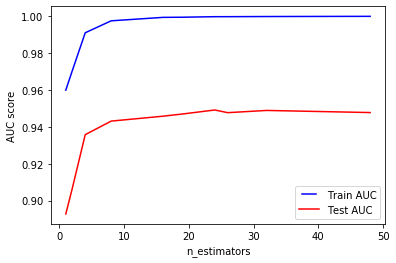

In [100]:
from sklearn.metrics import roc_curve, auc
n_estimators = [1, 2, 4, 8, 16, 19,24,26, 32,48]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

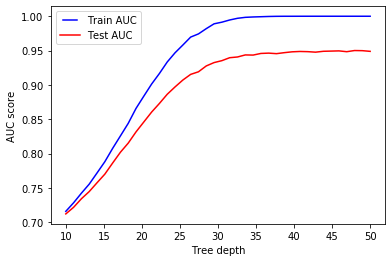

In [101]:
max_depths = np.linspace(10, 50, 40, endpoint=True)
train_results = []
test_results = []

# Loop through each of the max depths and train
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results,'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [119]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 40)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3,4,5, 10,]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True]
oob_score=[True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score': oob_score
              }


In [120]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rc_random = RandomizedSearchCV(estimator = rc,
                               param_distributions = random_grid,
                               n_iter = 25,
                               cv = 7,
                               verbose=5,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rc_random.fit(X_train, y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 9 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed: 22.6min finished


RandomizedSearchCV(cv=7, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [121]:
rc_random.best_params_

{'oob_score': True,
 'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 34,
 'bootstrap': True}

In [46]:
clf2 = RandomForestClassifier(class_weight="balanced",
                              oob_score=True,
                              max_depth = 34,
                              n_estimators=40,
                              random_state=0,
                              max_features='auto',
                              bootstrap=True,
                              min_samples_leaf=1,
                              min_samples_split=2)

In [110]:
clf2 = BaggingClassifier(oob_score=True,
                              n_estimators= 24,
                              random_state=0,
                              bootstrap=True)

In [111]:
X_train.head()

,clickCount,clickMin,clickMax,cartCount,cartMin,cartMax,cartTotal,cartStep,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,status_y,availability_completely not orderable,availability_completely orderable
278940,12,9.99,47.99,1,14.99,14.99,14.99,2.0,11400.0,533.0,128.0,52.0,38.0,2.0,4.0,5,5.0,2873.313,1.0,120.96,1,0,1
290063,10,24.99,99.99,1,24.99,24.99,24.99,1.0,600.0,559.0,70.0,22.0,27.0,2.0,14.0,6,6.0,1627.568,1.0,299.91,1,0,1
73780,7,7.99,24.99,5,7.99,24.99,77.95,0.0,2500.0,525.0,221.0,17.0,48.0,2.0,29.0,22,22.0,8013.668,1.0,15.98,0,0,0
135593,37,3.99,29.99,6,5.99,19.99,33.97,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,25,-1.0,53444.533,0.0,432.35,0,0,0
228000,9,9.99,29.99,9,9.99,29.99,172.91,0.0,4000.0,560.0,142.0,15.0,49.0,2.0,10.0,34,34.0,35362.259,1.0,0.00,0,0,0


In [47]:
clf2.fit(X_train, y_train)
#print(clf2.feature_importances_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [48]:
features = X_train.columns.values
importances = clf2.feature_importances_
indices = np.argsort(importances)
pprint(clf2.get_params())
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [125]:
clf2.score(X_test, y_test)

0.9572763059235191

In [126]:
results = clf2.predict(df_test_cl)

## Get results as csv

1. I create a dataframe with the sessionsID from the test dataset and join it to the results to get a dataframe `"sessionId","order"`. Then we have to  flatten the sessionIds are we get duplicates. 
1. I  sort by order , 1s would be first for a given session ID and then drop all the duplicates
1. I then convert the 1 to y and 0 to n for oder
1. last step is writing out to a csv file

In [127]:
df_results = pd.DataFrame({"sessionID":df_test.sessionID, "order_int":results})
df_results.sort_values(by=['order_int'], ascending=False)
df_dist  = df_results.drop_duplicates(subset = "sessionID", )
df_dist.head()

,sessionID,order_int
0,50001,1
9,50002,1
20,50003,1
43,50004,1
49,50005,0


In [128]:
df_dist.loc[df_dist['order_int']==1,'order'] = 'y'
df_dist['order'].fillna('n', inplace=True)
df_final = df_dist.drop('order_int',axis=1)
df_final.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pan

,sessionID,order
0,50001,y
9,50002,y
20,50003,y
43,50004,y
49,50005,n


In [129]:
df_final.to_csv("../data/results.csv", index=False)

Automatically created module for IPython interactive environment


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

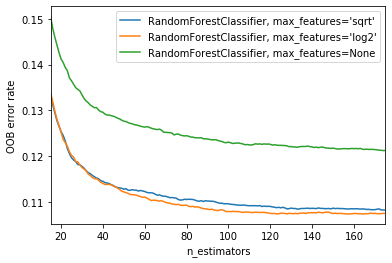

In [100]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 30
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()